### LSTM 모델
#### activation = tanh

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [ ]:
actions = ['one', 'two', 'three', 'four', 'five', 'select', 'up', 'ok']

In [ ]:
actions = ["one", "two", "three", "four", "five", "select", "up", "ok"]
secs_for_action = 30
seq_length = 30

In [ ]:
import os

# .npy 파일들이 있는 디렉토리 경로 설정
directory_path = '/content/drive/MyDrive/DeepLearning/gesture_control/dataset_seq30'

# 디렉토리 내의 모든 .npy 파일을 저장할 빈 리스트 생성
npy_files = []

# 디렉토리 내 모든 .npy 파일 찾기
for filename in os.listdir(directory_path):
    if filename.endswith(".npy"):
        file_path = os.path.join(directory_path, filename)
        npy_file = np.load(file_path)
        npy_files.append(npy_file)

# 빈 리스트에 저장된 .npy 파일들을 수직으로 concatenate
data = np.concatenate(npy_files, axis=0)

# 데이터 확인
print(data.shape)

(125371, 30, 100)


In [ ]:
print(data.shape)

(125371, 30, 100)


In [ ]:
# data의 마지막 값이 라벨이므로 X_data와 labels(정답)로 나누기
X_data = data[:, :, :-1]
labels = data[:, 0, -1]

In [ ]:
print(X_data.shape)
print(labels.shape)

(125371, 30, 99)
(125371,)


In [ ]:
# labels(정답) One-hot encoding
Y_data = to_categorical(labels, num_classes=len(actions))
Y_data.shape

(125371, 8)

In [ ]:
from sklearn.model_selection import train_test_split
X_data = X_data.astype(np.float32)
Y_data = Y_data.astype(np.float32)
X_train, X_val, y_train, y_val = train_test_split(X_data, Y_data, test_size=0.2, random_state=48)

In [ ]:
# 데이터 스플릿 --> 데이터 shape 확인
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(100296, 30, 99)
(100296, 8)
(25075, 30, 99)
(25075, 8)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# LSTM
# activation = "tanh"
model = Sequential([
    LSTM(64, activation='tanh', input_shape = X_train.shape[1:3]),
    Dense(32, activation='tanh'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 44,328
Trainable params: 44,328
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
h = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('/content/drive/MyDrive/DeepLearning/gesture_control/models/LSTM_tanh_seq30.h5',
                        monitor='val_acc',
                        verbose=1,
                        save_best_only=True,
                        mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
3128/3135 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9920
Epoch 1: val_acc improved from -inf to 0.99645, saving model to /content/drive/MyDrive/DeepLearning/gesture_control/models/LSTM_tanh_seq30.h5
3135/3135 [==============================] - 23s 5ms/step - loss: 0.0393 - acc: 0.9920 - val_loss: 0.0107 - val_acc: 0.9965 - lr: 0.0010
Epoch 2/200
3130/3135 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9961
Epoch 2: val_acc improved from 0.99645 to 0.99709, saving model to /content/drive/MyDrive/DeepLearning/gesture_control/models/LSTM_tanh_seq30.h5
3135/3135 [==============================] - 15s 5ms/step - loss: 0.0118 - acc: 0.9961 - val_loss: 0.0092 - val_acc: 0.9971 - lr: 0.0010
Epoch 3/200
3127/3135 [============================>.] - ETA: 0s - loss: 0.0093 - acc: 0.9967
Epoch 3: val_acc improved from 0.99709 to 0.99765, saving model to /content/drive/MyDrive/DeepLearning/gesture_control/models/LSTM_tanh_seq30.h5
3135/3135 [=

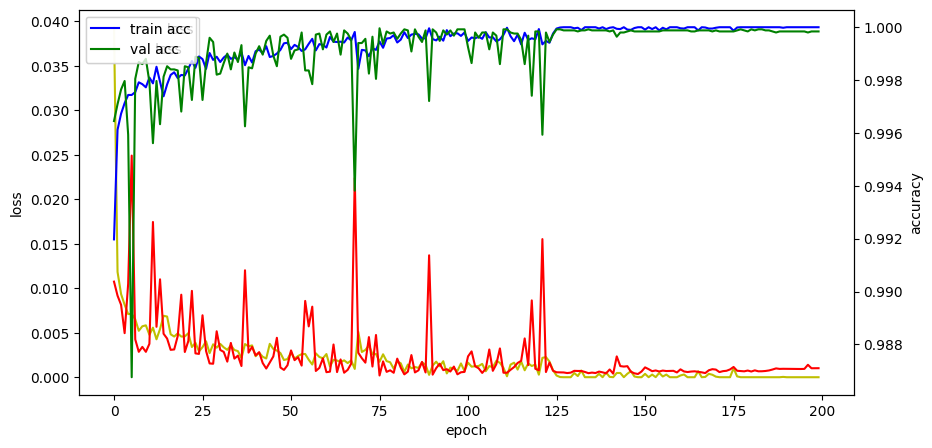

In [ ]:
import matplotlib.pyplot as plt

# 그래프 확인
fig, loss_ax = plt.subplots(figsize=(10, 5))
acc_ax = loss_ax.twinx()

loss_ax.plot(h.history['loss'], 'y', label='train loss')
loss_ax.plot(h.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(h.history['acc'], 'b', label='train acc')
acc_ax.plot(h.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

In [ ]:
model = load_model('/content/drive/MyDrive/DeepLearning/gesture_control/models/LSTM_tanh_seq30.h5')

y_pred = model.predict(X_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

784/784 [==============================] - 2s 2ms/step


array([[[21965,     0],
        [    0,  3110]],

       [[21913,     0],
        [    0,  3162]],

       [[21913,     0],
        [    0,  3162]],

       [[21990,     0],
        [    0,  3085]],

       [[21887,     0],
        [    0,  3188]],

       [[22017,     1],
        [    0,  3057]],

       [[21937,     0],
        [    1,  3137]],

       [[21902,     0],
        [    0,  3173]]])

In [ ]:
# len(X_val) : 326 (0 ~ 325)
# actions : zero, one, two, three, four, five
y_pred = model.predict(X_val)
pre = y_pred[2]
print("pre >> ", pre)
predict = np.argmax(pre)
print("predict >> ", predict)
predict_result = actions[predict]
print("추론결과는 {} 입니다.".format(predict_result))

784/784 [==============================] - 2s 2ms/step
pre >>  [9.9999952e-01 4.4451895e-08 9.6655937e-09 7.3097906e-09 5.4060791e-08
 4.8082597e-07 1.2554732e-10 4.1598816e-12]
predict >>  0
추론결과는 one 입니다.
